# ATTENTION:
This is a work in progress.
What I'm trying to demonstrate here does not yet actually work; I'm still figuring out how to do train an LSTM on ECG data.

# Introduction

In this notebook, we will train an LSTM network to predict electrocardiography (ECG) curves.

Let's first import a few packages that are needed.

In [1]:
%matplotlib inline

import urllib.request
import struct
import numpy as np

from sklearn.preprocessing import MinMaxScaler

from matplotlib import pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

/home/tatome/anaconda3/envs/default_env/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using Theano backend.


Ignore the warning above; it's a nuisance that's related to the specific version of h5py I've got installed on my computer.

One more thing before we load and preprocess the data: we want nice, large graphs throughout this notebook.
The following settings gives us that:

In [2]:
plt.rcParams["figure.figsize"] = (15,10)

# The Data

We'll load one of the data sets available at [physionet (see below)](https://www.physionet.org/physiobank/database/ptbdb/).   

In [3]:
url = 'https://www.physionet.org/physiobank/database/ptbdb/patient001/s0010_re.dat'
with urllib.request.urlopen(url) as infile:
    binary_data = infile.read()

The data is stored as raw, low-endian, unsigned integers.
NumPy knows how to deal with that:

In [4]:
data = np.frombuffer(binary_data, dtype='<h')

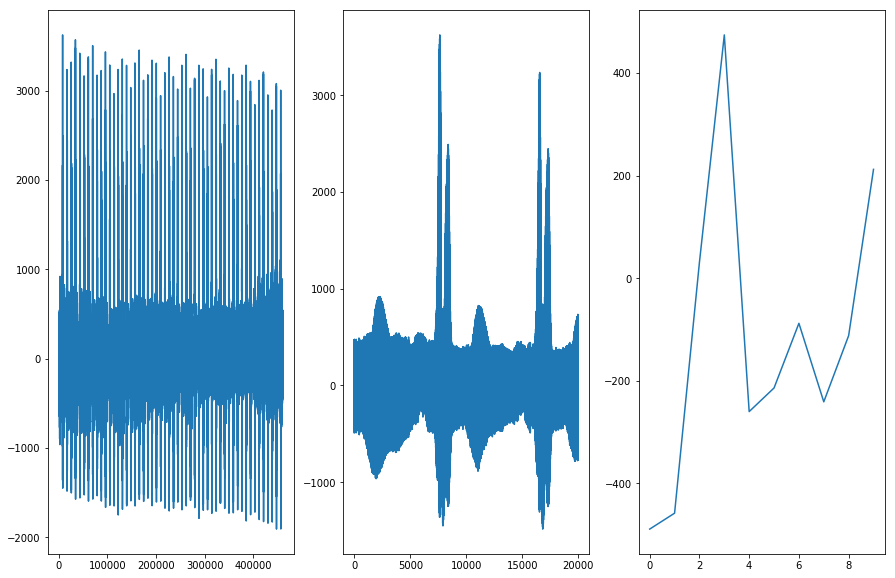

In [5]:
fig,axess = plt.subplots(ncols=3)
axess[0].plot(data)
axess[1].plot(data[:20000]);
axess[2].plot(data[:10])

The data is oscillating (due to the recording mechanism) and trended.
It doesn't make sense to learn the oscillation and the trend is better taken care of by other methods than LSTMs.
We'll smoothen and de-trend the data:

In [6]:
smoothing_filter = np.exp(-np.linspace(-3.5,3.5,500)**2)
smoothing_filter /= smoothing_filter.sum()

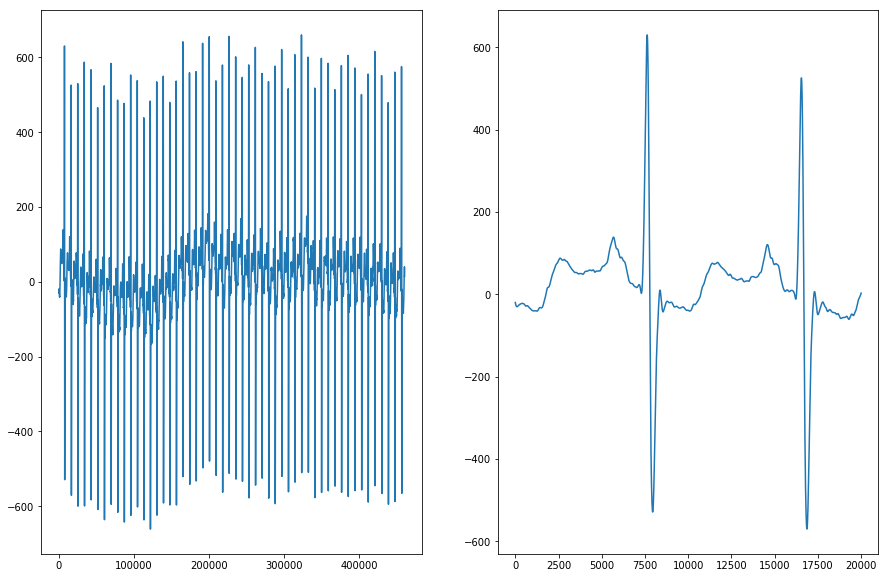

In [7]:
smooth_data = np.convolve(data, smoothing_filter, mode='same')
fig,axess = plt.subplots(ncols=2)
axess[0].plot(smooth_data)
axess[1].plot(smooth_data[:20000]);

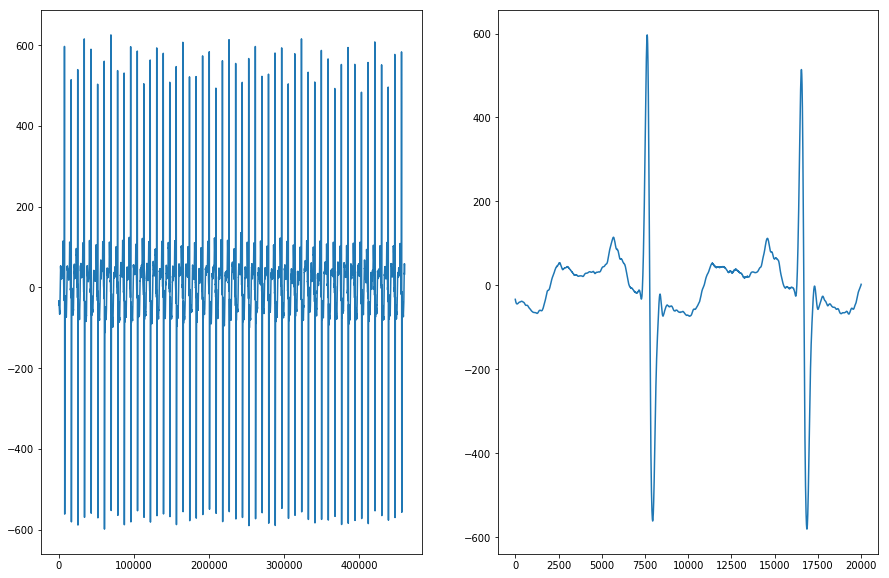

In [8]:
detrending_filter = np.exp(-np.ones(shape=10000))
detrending_filter /= detrending_filter.sum()

detrended_data = smooth_data - np.convolve(data, detrending_filter, mode='same')
fig,axess = plt.subplots(ncols=2)
axess[0].plot(detrended_data)
axess[1].plot(detrended_data[:20000]);

Next, we'll scale the data such that it falls between 0.125 and 0.875.
The network we'll train can in principle represent numbers between 0 and 1, not including, but values close to the boundaries are hard to represent by the sigmoid basis functions.

In [9]:
scaled = detrended_data - detrended_data.min()
scaled /= scaled.max() / .75
scaled += .125
print(scaled.min(), scaled.max())

0.125 0.875


If we were to make actual predictions about the real world, we'd have to store the original min and max of the data so we could scale our predictions to fit the actual input.
We might also use Keras' [MinMaxScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) for that job, but we won't bother, here. 

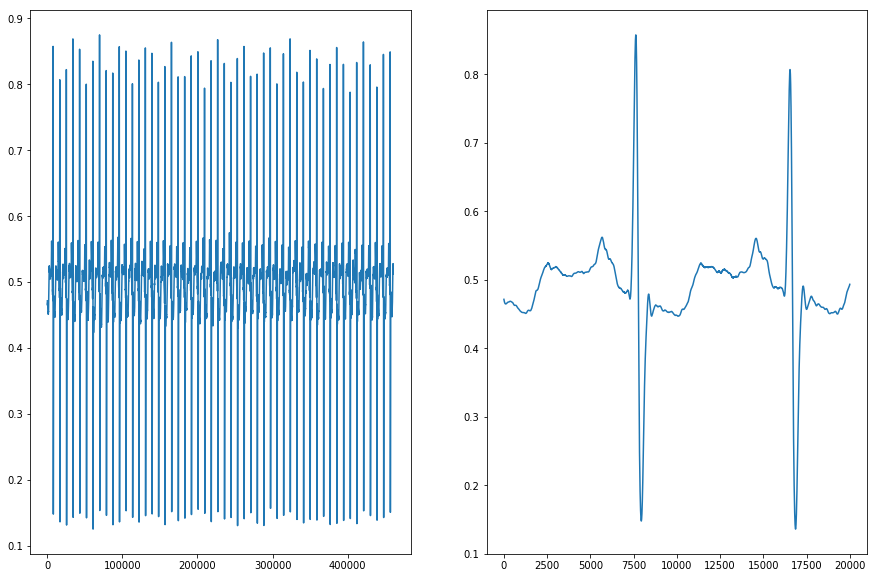

In [10]:
fig,axess = plt.subplots(ncols=2)
axess[0].plot(scaled)
axess[1].plot(scaled[:20000])

The last thing before we use our data to train a network is to split it into train and test sets.
This is conceptually a bit more tricky than for regular regression and classification problems, but we'll ignore that for now and just cut off the last third of the sequence as training data.

In [11]:
training_sequence = scaled[:-int(.333 * len(scaled))]
test_sequence = scaled[-int(.333*len(scaled)):]

print("Length of training, test data set: %d, %d." % (len(training_sequence), len(test_sequence)))

Length of training, test data set: 307354, 153446.


# Training

At this point, we could generate a large n-by-m array of n partial time series of length m that we can train our model on.

What we'll do instead is define a [generator function](https://wiki.python.org/moin/Generators) that creates a smaller number of sub-sequences (and target values) that the training procedure can call every time it is ready to process a new batch.

This has the benefit of effectively providing a more diverse training data set using less memory. 

In [12]:
def generate_samples(batch_size, sample_length, data = training_sequence):
    batch_idxs = np.ones(shape=(batch_size,sample_length + 1, 1), dtype=int)
    max_sequence_start_index = len(data) - sample_length - 1 
    while True:
        batch_idxs[:] = 1
        batch_idxs[:,0,0] = np.random.randint(0, max_sequence_start_index, size=batch_size)
        batch_idxs = np.cumsum(batch_idxs, axis=1).astype(int)
        
        batch = data[batch_idxs]
        yield batch[:,:-1,:], batch[:,-1,:]

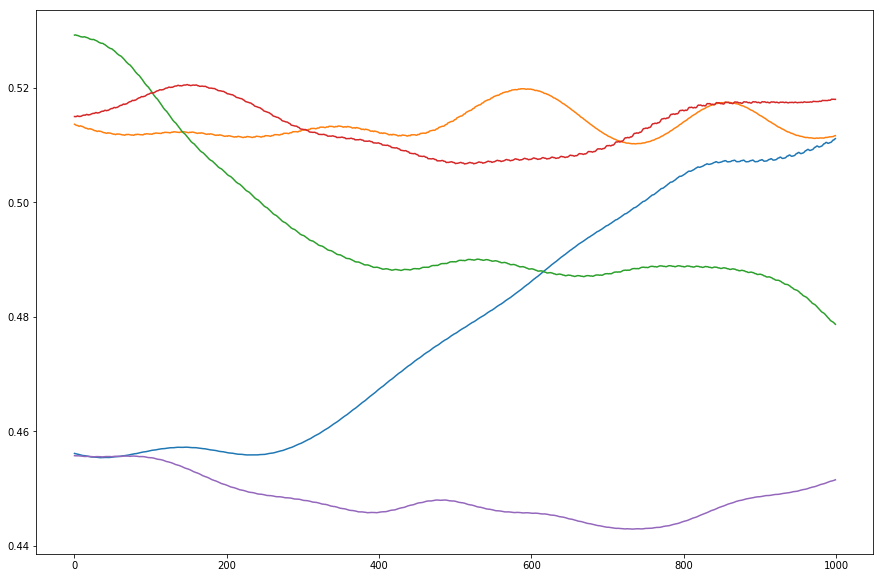

In [13]:
look_back = 1000

for batch,_ in zip(generate_samples(5, look_back), (0,)):
    plt.plot(batch[0][:,:,0].T);

That looks about right: five nice, smooth sequences of 1000 time steps, each.

Now, on to model training.
We'll train a simple network consisting of a single LSTM layer with an input dimensionality of 1 and a sequence length given by the variable `look_back` and a single-output `Dense` layer to make a one-step prediction, meaning a prediction for the 1001st step of a sub-sequence of our ECG data given the 1000 preceding steps.

In [14]:
batch_size=64
batch_generator = generate_samples(
    batch_size=batch_size, 
    sample_length=look_back
)

model = Sequential()
model.add(LSTM(32, input_shape=(look_back, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit_generator(batch_generator, epochs=50, steps_per_epoch=20, verbose=0)

# Testing

Different performance measures may be appropriate for our model, depending on the application.
Here, we'll just eyeball the recursive long-term prediction, given a 1000-step prefix, and see if it's similar to the actual course of the time series.

In [15]:
test_data_generator = generate_samples(
    batch_size=10, 
    sample_length=look_back+10000,
    data=test_sequence
)
test_data, = zip(test_data_generator, (0,))
test_data = test_data[0][0]

So, we have a test data set generated from the last third of our time series and we'll use the first 1000 points in our series to predict the 1001st step.
After that, we'll use the first 999 points of the original test sequence, plus our prediction, to predict the 1002nd step.
We'll rinse and repeat until we've predicted the next 9000 steps.

In [16]:
predictions = test_data.copy()
for i in range(look_back+1,predictions.shape[1]):
    predictions[:,i,:] = model.predict(predictions[:,i-look_back:i,:])

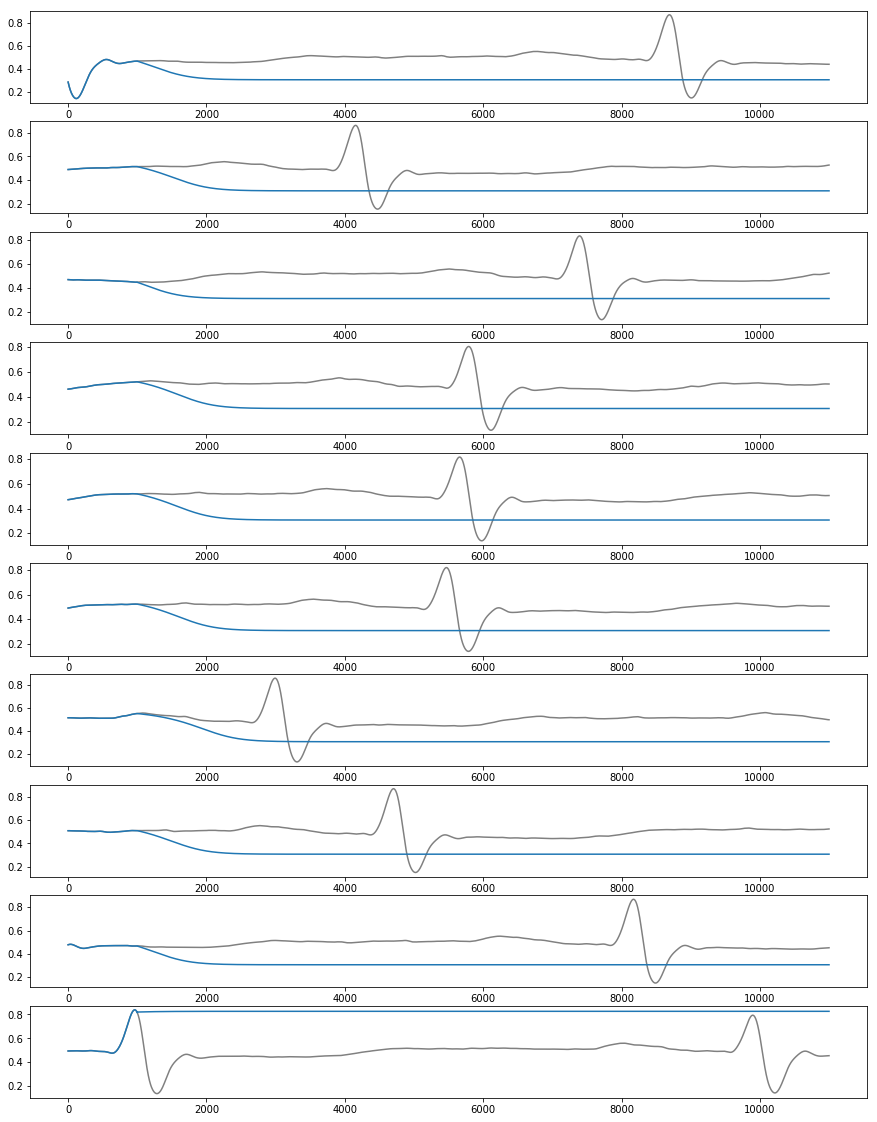

In [17]:
_,axess = plt.subplots(nrows=10, figsize=(15,20))

for real,predicted,axes in zip(test_data, predictions, axess):
    axes.plot(real[:,0], color='grey')
    axes.plot(predicted[:,0])


That's actually not very impressive!
Our predicted time series smoothly takes off from the last point it was given and then levels off somewhere around 0.4 for most cases (around 0.8 for the last).
Why does that happen?
Do we need a larger first LSTM layer?
More LSTM layers?
Should we train the network to the predict the n+16th time step instead of the next to force it to generalize?

# Citation

The database used here is described in
Bousseljot R, Kreiseler D, Schnabel, A. Nutzung der EKG-Signaldatenbank CARDIODAT der PTB über das Internet. Biomedizinische Technik, Band 40, Ergänzungsband 1 (1995) S 317

Physionet ask to cite the following publication:
Goldberger AL, Amaral LAN, Glass L, Hausdorff JM, Ivanov PCh, Mark RG, Mietus JE, Moody GB, Peng C-K, Stanley HE. PhysioBank, PhysioToolkit, and PhysioNet: Components of a New Research Resource for Complex Physiologic Signals. Circulation 101(23):e215-e220 [Circulation Electronic Pages; http://circ.ahajournals.org/content/101/23/e215.full]; 2000 (June 13). 